# Chapter 7. Telling birds from airplanes: Learning from images

## Imports

In [43]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets
from torchvision import transforms

## Download CIFAR-10

In [2]:
data_path = "/Volumes/OXYTOCIN/datasets/cifar10"

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100.0%


Extracting /Volumes/OXYTOCIN/datasets/cifar10/cifar-10-python.tar.gz to /Volumes/OXYTOCIN/datasets/cifar10
Files already downloaded and verified


## The `Dataset` class

In [3]:
len(cifar10)

50000

<PIL.Image.Image image mode=RGB size=32x32 at 0x7FCE3B894F40> 1 automobile


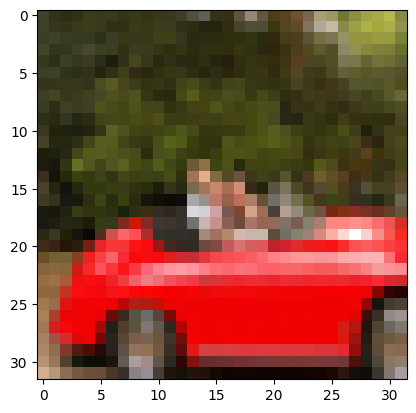

In [6]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
               
img, label = cifar10[99]
print(img, label, class_names[label])

plt.imshow(img)
plt.show()

### Dataset transforms

In [8]:
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_pil_constants',
 '_presets',
 'autoaugment',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [9]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
print(img_t.shape)

torch.Size([3, 32, 32])


In [23]:
# we can specify the transforms when we initialize the dataset
tensor_cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.ToTensor()
)

In [13]:
img_t, _ = tensor_cifar10[99]
print(type(img_t))
print(img_t.shape, img_t.dtype)

<class 'torch.Tensor'>
torch.Size([3, 32, 32]) torch.float32


In [14]:
# show that ToTensor rescales RGB values between 0 and 1
print(img_t.min(), img_t.max())

tensor(0.) tensor(1.)


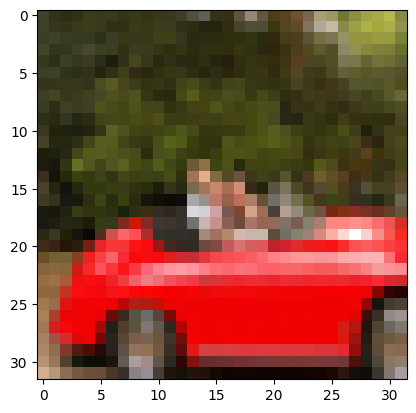

In [15]:
# verify image
plt.imshow(img_t.permute(1, 2, 0)) # change CHW to HWC
plt.show()

### Normalizing data

In [18]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3) # create a new dimension
print(imgs.shape)

torch.Size([3, 32, 32, 50000])


In [22]:
# imgs.view leaves the 3 channels alone but makes taking the mean simply over 1 dimension
mean = tuple(imgs.view(3, -1).mean(dim=1).tolist())
std = tuple(imgs.view(3, -1).std(dim=1).tolist())
print(mean, std)

(0.4913996458053589, 0.48215845227241516, 0.44653093814849854) (0.24703224003314972, 0.24348513782024384, 0.26158785820007324)


In [24]:
transformed_cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


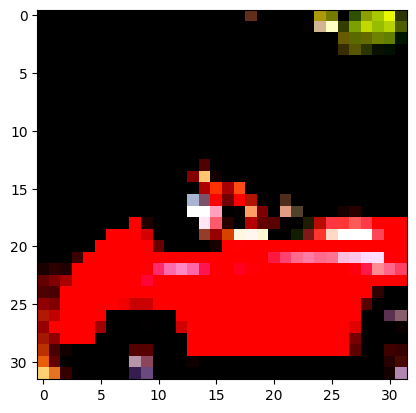

In [25]:
img_t, _ = transformed_cifar10[99]
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## Bird/airplane classifier

In [37]:
# building a dataset using a subset of cifar10

transformed_cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

transformed_cifar10_val = datasets.CIFAR10(
    data_path,
    train=False,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
)

label_map = {0: 0, 2: 1} # cifar10 -> cifar2
class_names = ["airplane", "bird"]

cifar2 = [(img, label_map[label])
          for img, label in transformed_cifar10
          if label in {0, 2}]
cifar2_val = [(img, label_map[label])
              for img, label in transformed_cifar10_val
              if label in {0, 2}]

In [29]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [30]:
x = torch.tensor([1.0, 2.0, 3.0])
print(softmax(x))

tensor([0.0900, 0.2447, 0.6652])


In [33]:
print(softmax(x).sum())

tensor(1.)


In [34]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

print(softmax(x))

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


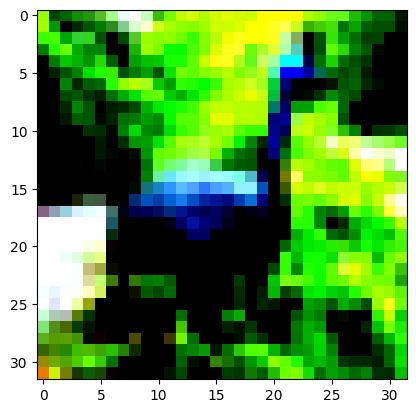

In [38]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

In [39]:
img_batch = img.view(-1).unsqueeze(0)

out = model(img_batch)
print(out)

tensor([[0.5427, 0.4573]], grad_fn=<SoftmaxBackward0>)


In [41]:
_, index = torch.max(out, dim=1)
print(index.tolist())

[0]


In [42]:
# define the model
n_out = 2
model = nn.Sequential(
    nn.Linear(
        3072, # 32x32
        512,  # hidden layer of size 512
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out
    ),
    nn.LogSoftmax(dim=1)
)

loss = nn.NLLLoss()
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))
print(loss(out, torch.tensor([label])))

tensor(0.6331, grad_fn=<NllLossBackward0>)


### Training

#### Naive iteration over dataset

In [ ]:
# define the model
n_out = 2
model = nn.Sequential(
    nn.Linear(
        3072, # 3x32x32
        512,  # hidden layer of size 512
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out
    ),
    nn.LogSoftmax(dim=1)
)
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch}, Loss: {float(loss):.4f}")


In [47]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch in {1, 2, 3, 98, 99} or epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {float(loss):.4f}")

Epoch 0, Loss 0.3572
Epoch 1, Loss 0.3849
Epoch 2, Loss 0.3386
Epoch 3, Loss 0.4812
Epoch 10, Loss 0.2271
Epoch 20, Loss 0.3639
Epoch 30, Loss 0.2797
Epoch 40, Loss 0.0911
Epoch 50, Loss 0.0903
Epoch 60, Loss 0.0238
Epoch 70, Loss 0.0654
Epoch 80, Loss 0.0448
Epoch 90, Loss 0.0515
Epoch 98, Loss 0.0071
Epoch 99, Loss 0.0102


#### Validation

In [48]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print(f"Accuracy: {correct / total}")

Accuracy: 0.8205


#### `nn.CrossEntropyLoss` instead of `nn.NLLLoss`

In [49]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3 * 32 * 32, 512),
    nn.Tanh(),
    nn.Linear(512, 2)) # no more LogSoftmax

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch in {1, 2, 3, 98, 99} or epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss {float(loss):.4f}")

Epoch 0, Loss 0.7066
Epoch 1, Loss 0.5536
Epoch 2, Loss 0.1922
Epoch 3, Loss 0.2291
Epoch 10, Loss 0.3388
Epoch 20, Loss 0.1402
Epoch 30, Loss 0.1791
Epoch 40, Loss 0.0996
Epoch 50, Loss 0.0701
Epoch 60, Loss 0.0380
Epoch 70, Loss 0.0208
Epoch 80, Loss 0.0213
Epoch 90, Loss 0.0200
Epoch 98, Loss 0.0152
Epoch 99, Loss 0.0123


In [50]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())

print(f"Accuracy (train): {correct / total}")

val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print(f"Accuracy (val): {correct / total}")

# we are overfitting to the training set

Accuracy (train): 0.9993
Accuracy (val): 0.8095


In [51]:
numel_list = [p.numel()
              for p in model.parameters()
              if p.requires_grad == True]

print(sum(numel_list), numel_list)

1574402 [1572864, 512, 1024, 2]
